In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import re
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode 

/home/umar/miniconda3/envs/firefly/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
label_dict_ = {
    "NN": (1, 13700),
    "YY": [(13701, 14699), (15981, 19802), (19900, 27183), (27515, 31294), (31510, 33597), (33930, 36550), (38031, 38153), (41642, 45279), (51207, 52286)],
    "YN": [(14700, 15980), (19803, 19899), (27184, 27514), (31295, 31509), (33598, 33929), (36551, 38030), (38154, 41642), (45280, 51206), (52287, 53451)],
}
# rewrite the label_dict so that we can easily lookup the label of a given frame based on the id
label_dict = {}
for key, value in label_dict_.items():
    if type(value) == tuple:
        for i in range(value[0], value[1]+1):
            label_dict[i] = key
    else:
        for i in value:
            for j in range(i[0], i[1]+1):
                label_dict[j] = key

In [3]:
def get_id_from_path(path):
    base = os.path.basename(path)
    og_filename, extension = os.path.splitext(base)
    id = og_filename.split(" ")[-1]
    id = re.sub(r'[()]', '', id)
    return int(id)

In [4]:
# Expected directory structure:
# FLAME2_base_dir  (shown in parallel here only for clarity)
#   RGB             #   Thermal
#       train       #       train
#           NN      #           NN
#           YY      #           YY
#           YN      #           YN
#       val         #       val
#           NN      #           NN
#           YY      #           YY
#           YN      #           YN
#       test        #       test    
#           NN      #           NN
#           YY      #           YY
#           YN      #           YN

In [5]:
# Define the preprocessing.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize for the ImageNet format.
        ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/umar/Pictures/datasets/FLAME2/Thermal/'

# Give a dataset with the lambda function to the function called ImageFolder of the module called dataset, and add the above preprocessing to make it a dataset format for torch.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} 


# Calculate the optimal batch size

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Class names: ", class_names)
print("Device: ", device)


Class names:  ['NN', 'YN', 'YY']
Device:  cuda:0


In [7]:
model_ft = models.resnet18(pretrained=True) # Pretrained model.

/home/umar/miniconda3/envs/firefly/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umar/miniconda3/envs/firefly/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Give the above data to the loader that loads the data during training
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

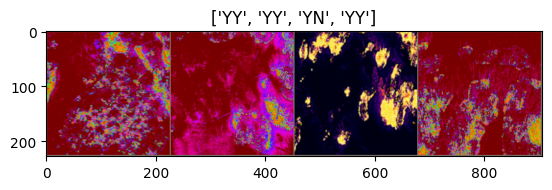

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) # denormalize     
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated 

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
num_ftrs = model_ft.fc.in_features # The feature output of the pretrained model.

# A neural network that receives the output of the output shape of the pre-trained model
# as an input and outputs the number of classes to be classified this time is added as a fine tune layer.
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------


100%|██████████| 12769/12769 [02:08<00:00, 99.37it/s] 


train Loss: 0.0362 Acc: 0.9865


 20%|██        | 1/5 [02:09<08:38, 129.75s/it]

val Loss: 0.0092 Acc: 0.9967

Epoch 1/4
----------


100%|██████████| 12769/12769 [02:09<00:00, 98.61it/s] 


train Loss: 0.0310 Acc: 0.9891


 40%|████      | 2/5 [04:20<06:31, 130.34s/it]

val Loss: 0.0054 Acc: 0.9983

Epoch 2/4
----------


100%|██████████| 12769/12769 [02:11<00:00, 96.95it/s]


train Loss: 0.0279 Acc: 0.9903


 60%|██████    | 3/5 [06:33<04:23, 131.55s/it]

val Loss: 0.0073 Acc: 0.9992

Epoch 3/4
----------


100%|██████████| 12769/12769 [02:07<00:00, 99.77it/s]


train Loss: 0.0180 Acc: 0.9936


 80%|████████  | 4/5 [08:42<02:10, 130.62s/it]

val Loss: 0.0042 Acc: 0.9992

Epoch 4/4
----------


100%|██████████| 12769/12769 [02:08<00:00, 99.26it/s]


train Loss: 0.0154 Acc: 0.9942


100%|██████████| 5/5 [10:52<00:00, 130.52s/it]

val Loss: 0.0041 Acc: 0.9992

Training complete in 10m 53s
Best val Acc: 0.999168


In [14]:
save_path_state_dict = './classification_weights/thermal_resenet18_epoch-5_state_dict.pth'
# save for inference
torch.save(model_ft.state_dict(), save_path_state_dict)

In [15]:
save_path_full = './classification_weights/thermal_resenet18_epoch-5_full_model.pth'
# also saving entire model for later to restart training incase the state_dict is not enough
torch.save(model_ft, save_path_full)

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)

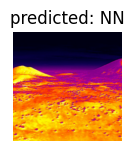

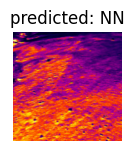

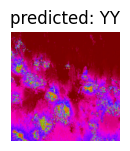

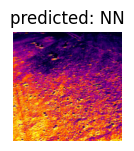

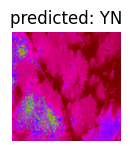

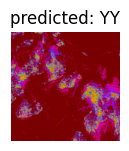

In [21]:
visualize_model(model_ft)